# End-to-End Lane Navigation via Nvidia Model
Original Author: David Tian

Modified by: Micah Dotzert

Date: 2020-03-31

This code is a modification of the code described in the [DeepPiCar - Part 5: Autonomous Lane Navigation via Deep Learning](https://medium.com/@dctian/deeppicar-part-5-lane-following-via-deep-learning-d93acdce6110?source=your_stories_page---------------------------) Blog.
The source code itself is a modification of code from the GitHub file [end_to_end_lane_navigation.ipynb](https://github.com/dctian/DeepPiCar/blob/master/models/lane_navigation/code/end_to_end_lane_navigation.ipynb)

In [43]:
#Mount personal Google Drive, will ask for authentication code.
from google.colab import drive
import os

drive.mount('/content/gdrive')
data_dir = "/content/gdrive/My Drive/Self-Driving-Car-Project/recordings/Blue-v6"
model_name = "Blue-Model-v6"
model_output_dir = '/content/gdrive/My Drive/Self-Driving-Car-Project/models/' + model_name
if not os.path.exists(model_output_dir):
  os.makedirs(model_output_dir)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [44]:
#imports

# python standard libraries
import os
import random
import fnmatch
import datetime
import pickle

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

#tensorflow
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  %tensorflow_version 1.x
except Exception:
  pass

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.models import load_model

print(f'tf.__version__: {tf.__version__}')
print(f'keras.__version__: {keras.__version__}')

#sklearn
from sklearn.model_selection import train_test_split

#imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

TensorFlow is already loaded. Please restart the runtime to change versions.
tf.__version__: 1.15.2
keras.__version__: 2.2.4-tf


image_path: /content/gdrive/My Drive/Self-Driving-Car-Project/recordings/Blue-v6/image_069_2002_28_235726_2.jpg
driving_command: turn right


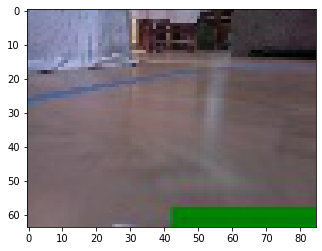

In [45]:
#import images
#!cd /content
#!git clone https://github.com/dctian/DeepPiCar

#!ls

command_list = ["turn left", "drive straight", "turn right", "stop"]

file_list = os.listdir(data_dir)
image_paths = []
driving_commands = []
pattern = '*.jpg'
for filename in file_list:
  if fnmatch.fnmatch(filename, pattern):
    image_paths.append(os.path.join(data_dir, filename))
    try:
      command = int(filename[-5])
      
    except ValueError:
      command = int(filename[-6])
    
    driving_commands.append(command)

image_index = 20
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index])
print("driving_command: %s" % command_list[driving_commands[image_index]])

(array([6.0000, 0.0000, 0.0000, 0.0000, 254.0000, 0.0000, 0.0000, 678.0000]),
 array([0.0000, 0.2500, 0.5000, 0.7500, 1.0000, 1.2500, 1.5000, 1.7500,
        2.0000]),
 <a list of 8 Patch objects>)

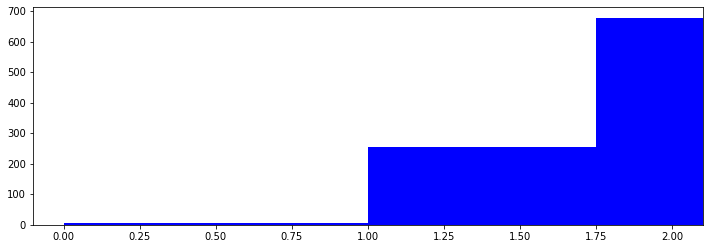

In [46]:
# Look at the distribution of the driving commands
num_of_bins = 8
samples_per_bin = 400
hist, bins = np.histogram(driving_commands, num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(driving_commands, bins=num_of_bins, width=1, color='blue')

Training data: 844
 Validation data: 94


Text(0.5, 1.0, 'Validation data')

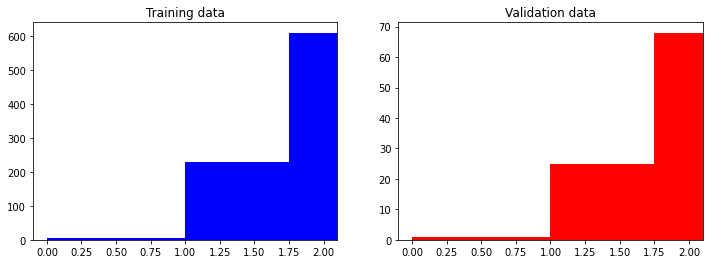

In [47]:
x_train, x_valid, y_train, y_valid = train_test_split(image_paths, driving_commands, test_size=0.1)
print('Training data: %d\n Validation data: %d' % (len(x_train), len(x_valid)))

#plot distributions of train and valid data to ensure consistency
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation data')

# Augment Images

Text(0.5, 1.0, 'zoomed')

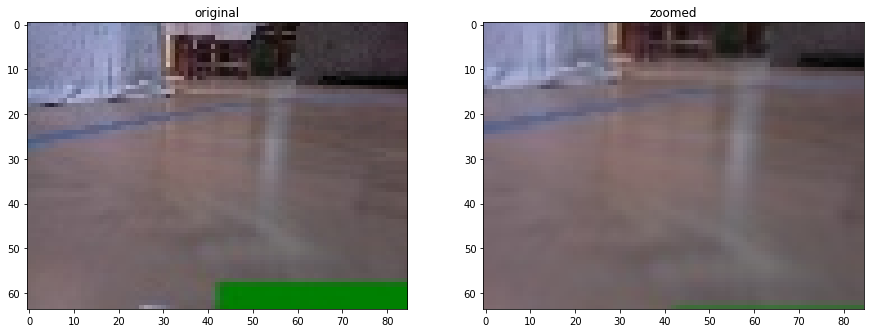

In [48]:
def my_imread(image_path):
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image

def zoom(image):
  zoom = img_aug.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

fig, axes = plt.subplots(1,2, figsize=(15,10))
image_orig = my_imread(image_paths[image_index])
image_zoom = zoom(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("original")
axes[1].imshow(image_zoom)
axes[1].set_title("zoomed")

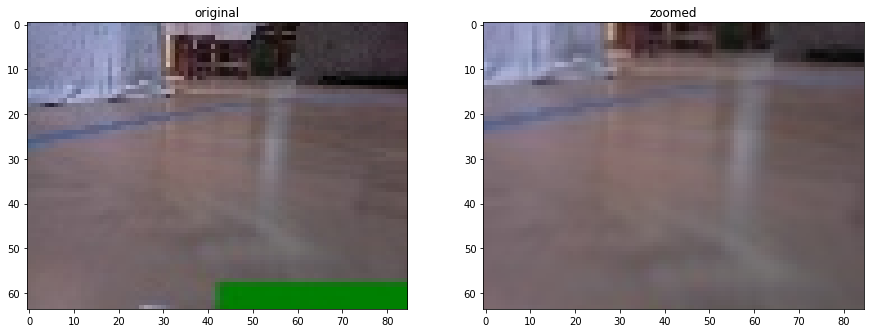

In [49]:
def compare_images(text1 = 'original', text2 = 'modified', modifier_function = my_imread, image1 = my_imread(image_paths[image_index])):
  fig, axes = plt.subplots(1,2, figsize=(15,10))
  image_orig = image1
  image_modified = modifier_function(image_orig)
  axes[0].imshow(image_orig)
  axes[0].set_title(text1)
  axes[1].imshow(image_modified)
  axes[1].set_title(text2)

compare_images('original', 'zoomed', zoom)

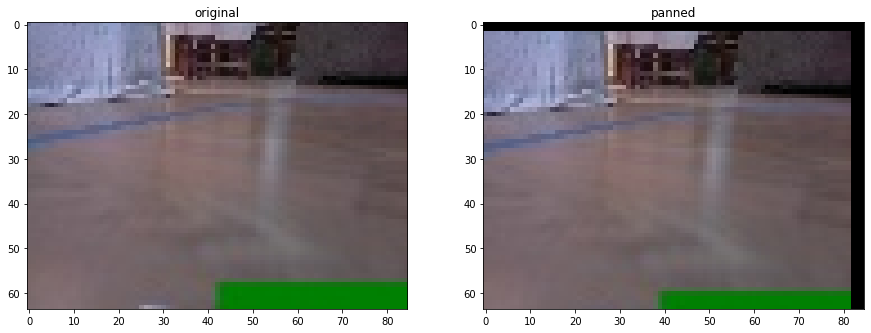

In [50]:
def pan(image):
  # pan left / right / up / down, about 10%
  pan = img_aug.Affine(translate_percent= {'x': (-0.1, 0.1), 'y': (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

compare_images('original', 'panned', pan)

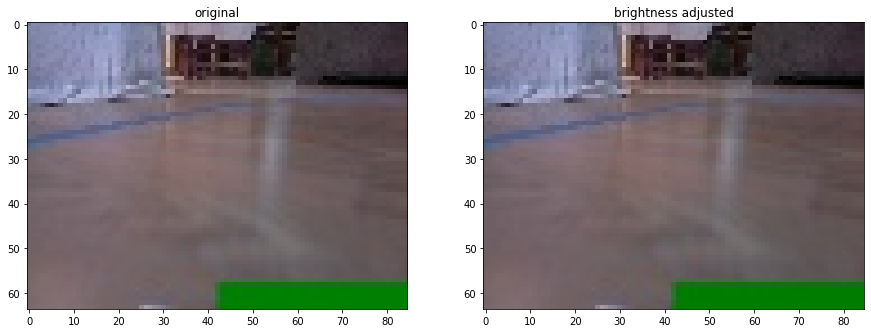

In [51]:
def adjust_brightness(image):
  # increase or decrease brightness by 30%
  brightness = img_aug.Multiply((0.7, 1.3))
  image = brightness.augment_image(image)
  return image

compare_images('original', 'brightness adjusted', adjust_brightness)

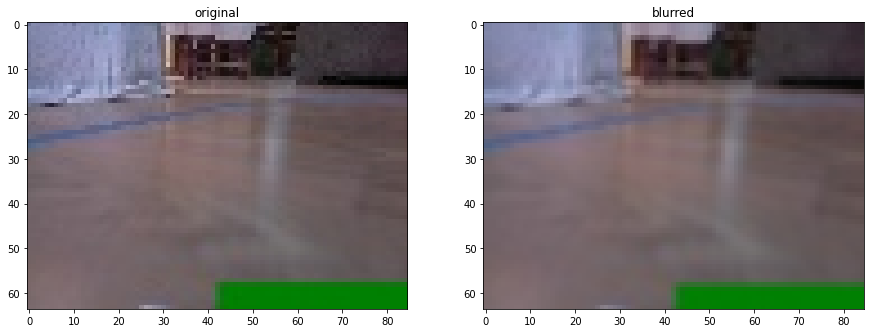

In [52]:
def blur(image):
  kernel_size = random.randint(1, 5) # kernel largeer than 5 would make the image way to blurry
  image = cv2.blur(image,(kernel_size, kernel_size))
  return image

compare_images('original', 'blurred', blur)

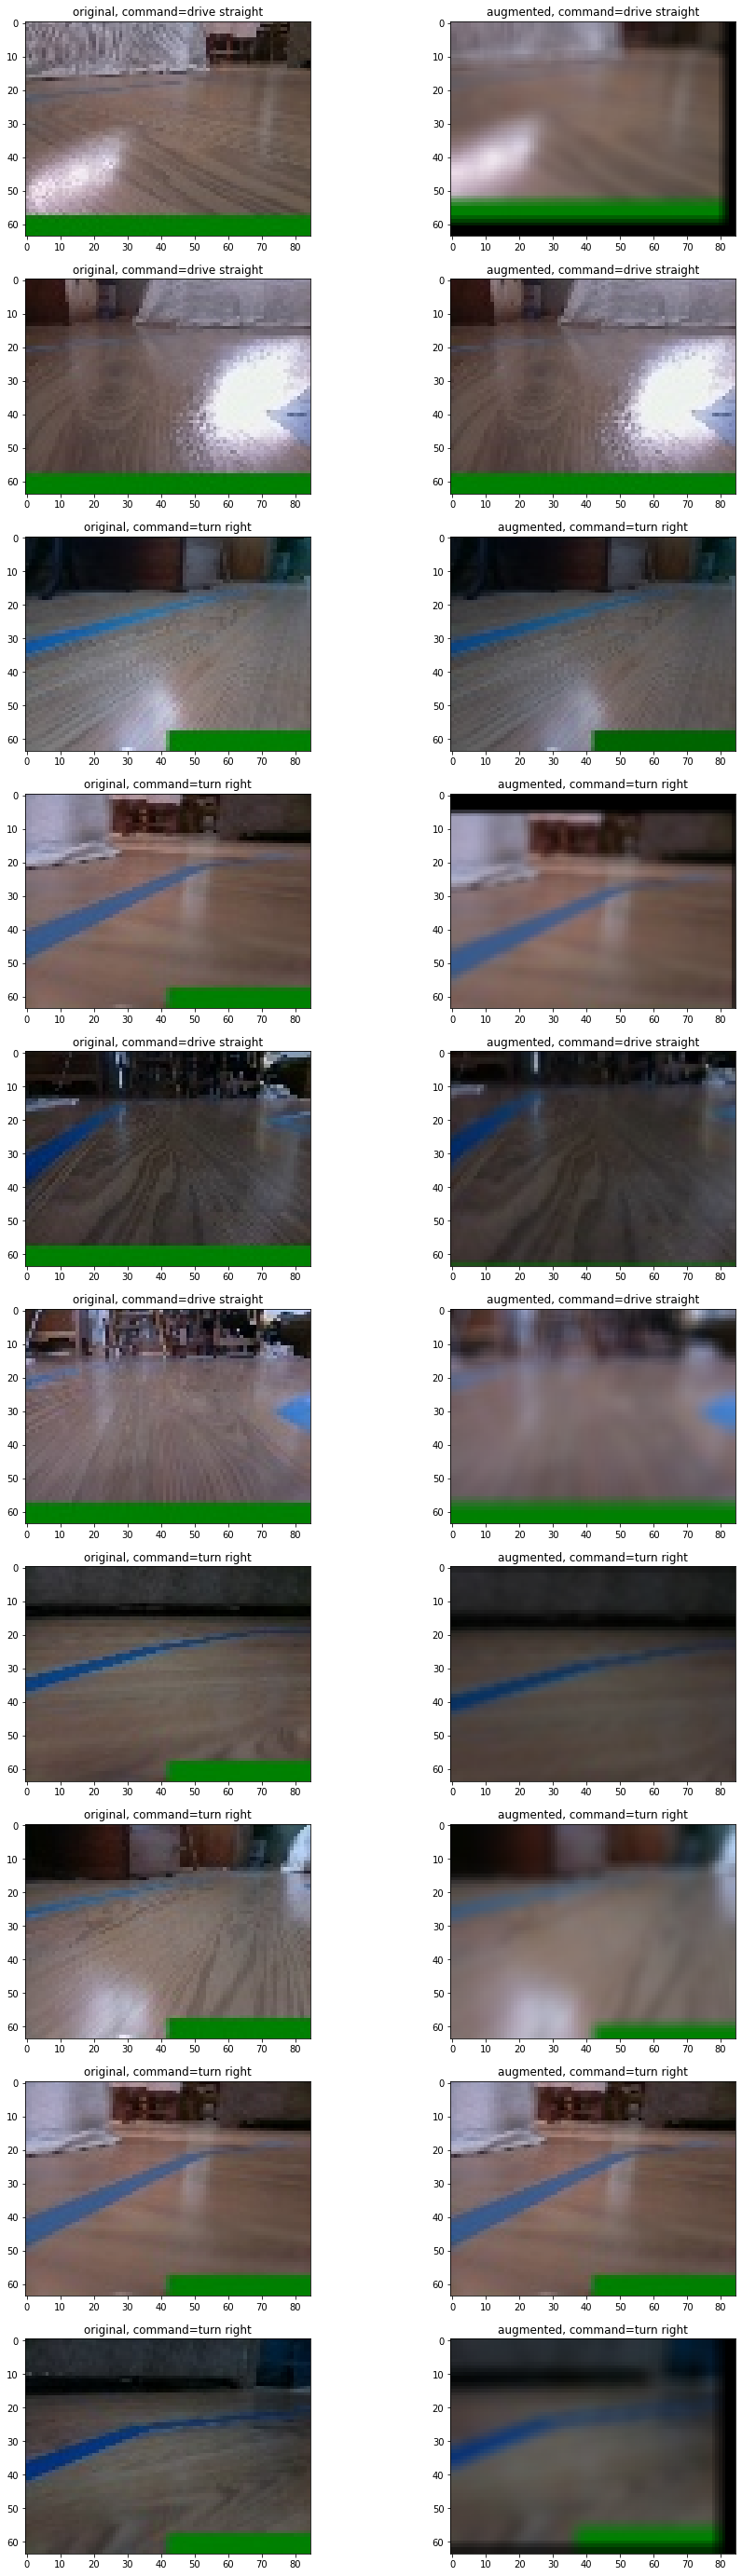

In [53]:
# put it together
def random_augment(image, driving_command):
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = blur(image)
  if np.random.rand() < 0.5:
    image = adjust_brightness(image)

  return image, driving_command

# show a few randomly augmented images
ncol = 2
nrow = 10
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 50))

for i in range(nrow):
  rand_index = random.randint(0, len(image_paths) - 1)
  image_path = image_paths[rand_index]
  driving_command_orig = driving_commands[rand_index]

  image_orig = my_imread(image_path)
  image_aug, driving_command_aug = random_augment(image_orig, driving_command_orig)

  axes[i][0].imshow(image_orig)
  axes[i][0].set_title('original, command=%s' % command_list[driving_command_orig])
  axes[i][1].imshow(image_aug)
  axes[i][1].set_title('augmented, command=%s' % command_list[driving_command_aug])

# Preprocess Training Data for Nvidia Model

Text(0.5, 1.0, 'processed')

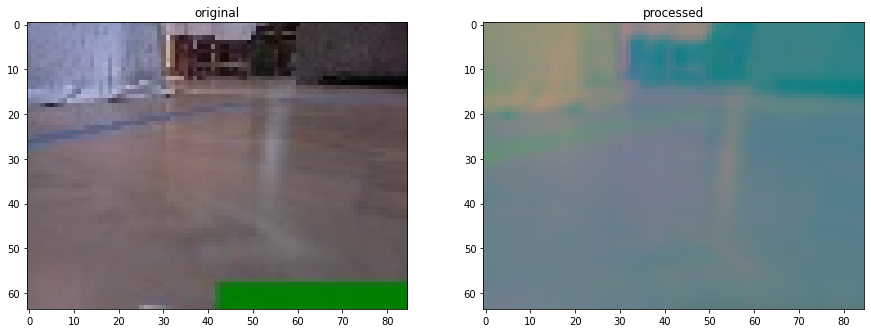

In [54]:
def img_preprocess(image):
  height, _, _ = image.shape
  #image = image[int(height/2):,:,:] # remove top half of the image, as it is not relavant for lane following
  image = image[:int(height-height//10),:,:] # remove bottom bit of image to eliminate displayed driving status visualization
  image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV) # Nvidia model said it best to use YUV color space
  image = cv2.GaussianBlur(image, (3,3), 0)
  image = cv2.resize(image, (85,64)) # input image size(85,64) Nvidia model
  image = image / 255 # normalizing, the processed image becomes black for some reason. Do we need this?
  return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title('original')
axes[1].imshow(image_processed)
axes[1].set_title('processed')

# Create and Train Model

In [0]:
# Experiment with smaller and hopefully faster models
def smaller_model():
  model = Sequential([
                      Conv2D(12, (5,5), input_shape=(64, 85, 3), activation='elu'),
                      #Conv2D(5, (5,5), activation='elu'),
                      Flatten(),
                      Dropout(0.2),
                      #Dense(10, activation='elu'),
                      Dense(4, activation='softmax')
  ], name="Smaller Model")

  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [0]:
def nvidia_model():

  # elu=Exponential Linear Unit, similar to leaky Relu
  # skipping 1st hidden layer (normalization layer), as we have normalized the data

  model = Sequential([
    # Convolution Layers
    Conv2D(24, (5, 5), strides=(2,2), input_shape=(64, 85, 3), activation='elu'),
    Conv2D(36, (5, 5), strides=(2,2), activation='elu'),
    Conv2D(48, (5, 5), strides=(2,2), activation='elu'),
    Conv2D(64, (3, 3), activation='elu'),
    Dropout(0.2), # not in original model. added for more robustness
    Conv2D(64, (3, 3), activation='elu'),

    #MaxPool2D(),
    # Fully Connected Layers
    Flatten(),
    Dropout(0.2), # not in original model. added for more robustness
    Dense(100, activation='elu'),
    Dense(50, activation='elu'),
    Dense(10, activation='elu'),

    # output layer: movement commands: go forward-left, forward-straight, forward-right, + stop
    Dense(4, activation='softmax')
  ], name='Nvidia_Model')

  
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model


In [57]:
model = nvidia_model()
print(model.summary())
# check that we will have 252,219 trainable parameters

Model: "Nvidia_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 30, 41, 24)        1824      
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 13, 19, 36)        21636     
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 5, 8, 48)          43248     
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 6, 64)          27712     
_________________________________________________________________
dropout_14 (Dropout)         (None, 3, 6, 64)          0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 1, 4, 64)          36928     
_________________________________________________________________
flatten_7 (Flatten)          (None, 256)              

In [0]:
def image_data_generator(image_paths, driving_commands, batch_size, is_training):
  while True:
    batch_images = []
    batch_driving_commands = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      image_path = image_paths[random_index]
      image = my_imread(image_paths[random_index])
      driving_command = driving_commands[random_index]
      if is_training:
        # training: augment image
        image, driving_command = random_augment(image, driving_command)
      
      image = img_preprocess(image)
      batch_images.append(image)
      batch_driving_commands.append(driving_command)
    
    yield(np.asarray(batch_images), np.asarray(batch_driving_commands))

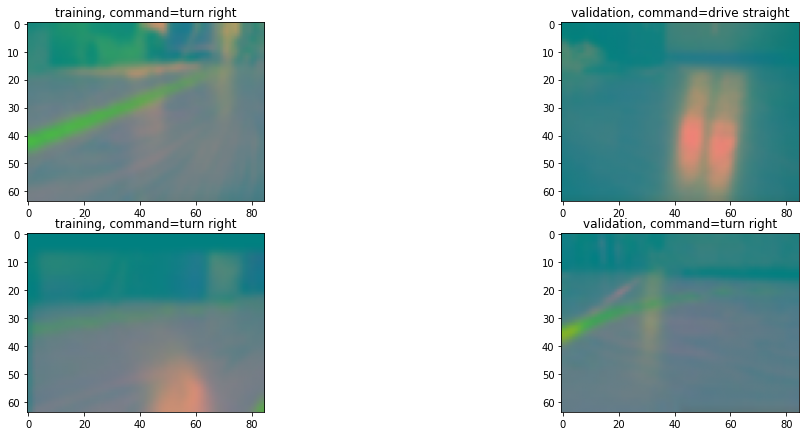

In [59]:
ncol = 2
nrow = 2

x_train_batch, y_train_batch = next(image_data_generator(x_train, y_train, nrow, True))
x_valid_batch, y_valid_batch = next(image_data_generator(x_valid, y_valid, nrow, False))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
  axes[i][0].imshow(x_train_batch[i])
  axes[i][0].set_title("training, command=%s" % command_list[y_train_batch[i]])
  axes[i][1].imshow(x_valid_batch[i])
  axes[i][1].set_title("validation, command=%s" % command_list[y_valid_batch[i]])

In [0]:
# start Tensorboard before model fit, so we can see the epoch tick in Tensorboard
# Jupyter Notebook embedded Tensorboard is a new feature in TF 2.0!!

# clean up log folder for tensorboard
log_dir_root = f'{model_output_dir}/logs/'
#!rm -rf $log_dir_root

In [61]:
# this block prevents the training from starting if we tell Colab to Run All
# it works by throwing an error when Colab reaches this code cell, 
# preventing the code below from being run automatically
DO_NOT_RUN_ALL

NameError: ignored

In [62]:
# save the model weights after each epoch if the validation loss decreased
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir, model_name + '_check.h5'))

#SendEmail('lane nav train started')
history = model.fit(image_data_generator(x_train, y_train, batch_size=30, is_training=True),
                              steps_per_epoch=30,
                              epochs=25,
                              validation_data = image_data_generator(x_valid, y_valid, batch_size=30, is_training=False),
                              validation_steps=20,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
# always save model output as soon as model finishes training
model.save(os.path.join(model_output_dir, model_name + '_final.h5'))

date_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'wb') as f:
  pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

#SendEmail('lane nav train finished. val_loss from %.1f to %.1f' % (history.history['val_loss'][0], history.history['val_loss'][-1]))

Epoch 1/25
30/30 [==============================] - 170s 6s/step - loss: 0.6940 - acc: 0.7011 - val_loss: 0.6145 - val_acc: 0.7133
Epoch 2/25
30/30 [==============================] - 36s 1s/step - loss: 0.6200 - acc: 0.7078 - val_loss: 0.5675 - val_acc: 0.7817
Epoch 3/25
30/30 [==============================] - 25s 842ms/step - loss: 0.5632 - acc: 0.7444 - val_loss: 0.7053 - val_acc: 0.7200
Epoch 4/25
30/30 [==============================] - 13s 441ms/step - loss: 0.5473 - acc: 0.7744 - val_loss: 0.5973 - val_acc: 0.7250
Epoch 5/25
30/30 [==============================] - 12s 392ms/step - loss: 0.5241 - acc: 0.7667 - val_loss: 0.5279 - val_acc: 0.8350
Epoch 6/25
30/30 [==============================] - 10s 343ms/step - loss: 0.5001 - acc: 0.7856 - val_loss: 0.5482 - val_acc: 0.8050
Epoch 7/25
30/30 [==============================] - 14s 463ms/step - loss: 0.4730 - acc: 0.8111 - val_loss: 0.4049 - val_acc: 0.8117
Epoch 8/25
30/30 [==============================] - 11s 353ms/step - loss:

In [63]:
history.history

{'acc': [0.70111114,
  0.7077778,
  0.74444443,
  0.77444446,
  0.76666665,
  0.78555554,
  0.8111111,
  0.84555554,
  0.8488889,
  0.83666664,
  0.8688889,
  0.87666667,
  0.85333335,
  0.8288889,
  0.8622222,
  0.8522222,
  0.8688889,
  0.8788889,
  0.9111111,
  0.89111114,
  0.90555555,
  0.9177778,
  0.90555555,
  0.9122222,
  0.9344444],
 'loss': [0.6940287331740062,
  0.6199573417504628,
  0.5632208794355392,
  0.547287784020106,
  0.524062113960584,
  0.500144162774086,
  0.47302195529143015,
  0.3689939824243387,
  0.39100056489308677,
  0.38410597940286,
  0.3168511226773262,
  0.3074716384212176,
  0.37900366882483166,
  0.4260350336631139,
  0.3190379833181699,
  0.35318156480789187,
  0.34014007995525997,
  0.297493423273166,
  0.24258392105499904,
  0.2940081516901652,
  0.2500210627913475,
  0.2314253993332386,
  0.23142054925362268,
  0.2283563474814097,
  0.1908478546887636],
 'val_acc': [0.7133333,
  0.7816667,
  0.72,
  0.725,
  0.835,
  0.805,
  0.81166667,
  0.875,


In [0]:
# always save model output as soon as model finishes training
model.save(os.path.join(model_output_dir, model_name + '_final.h5'))
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'wb') as f:
  pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)



In [0]:
history_path = os.path.join(model_output_dir,'history.pickle')

In [0]:
# plot training a validation losses
# this should be the same as tensorboard
#history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'rb') as f:
  history = pickle.load(f)

In [67]:
history

{'acc': [0.70111114,
  0.7077778,
  0.74444443,
  0.77444446,
  0.76666665,
  0.78555554,
  0.8111111,
  0.84555554,
  0.8488889,
  0.83666664,
  0.8688889,
  0.87666667,
  0.85333335,
  0.8288889,
  0.8622222,
  0.8522222,
  0.8688889,
  0.8788889,
  0.9111111,
  0.89111114,
  0.90555555,
  0.9177778,
  0.90555555,
  0.9122222,
  0.9344444],
 'loss': [0.6940287331740062,
  0.6199573417504628,
  0.5632208794355392,
  0.547287784020106,
  0.524062113960584,
  0.500144162774086,
  0.47302195529143015,
  0.3689939824243387,
  0.39100056489308677,
  0.38410597940286,
  0.3168511226773262,
  0.3074716384212176,
  0.37900366882483166,
  0.4260350336631139,
  0.3190379833181699,
  0.35318156480789187,
  0.34014007995525997,
  0.297493423273166,
  0.24258392105499904,
  0.2940081516901652,
  0.2500210627913475,
  0.2314253993332386,
  0.23142054925362268,
  0.2283563474814097,
  0.1908478546887636],
 'val_acc': [0.7133333,
  0.7816667,
  0.72,
  0.725,
  0.835,
  0.805,
  0.81166667,
  0.875,


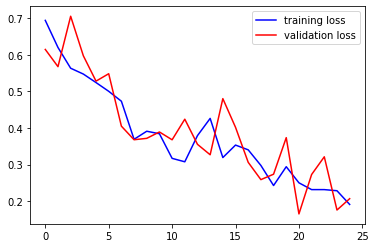

In [68]:
history
plt.plot(history['loss'],color='blue')
plt.plot(history['val_loss'],color='red')
plt.legend(['training loss', 'validation loss'])

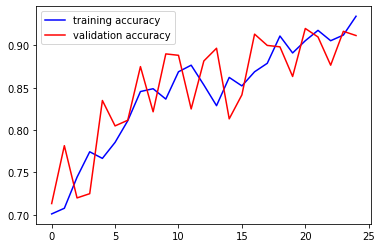

In [69]:
history
plt.plot(history['acc'], color='blue')
plt.plot(history['val_acc'], color='red')
plt.legend(['training accuracy', 'validation accuracy'])

2
[2]


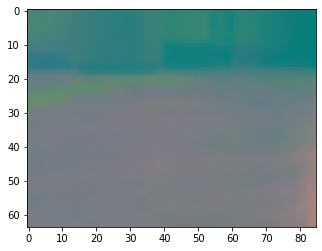

In [70]:
model = load_model(f'{model_output_dir}/{model_name}_final.h5')
x_test, y_test = next(image_data_generator(image_paths, driving_commands, 1, False))
y_pred = np.argmax(model.predict(x_test))
print(y_pred)
print(y_test)

plt.imshow(x_test[0])

In [0]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(y_true, y_pred):

  mse = mean_squared_error(y_true, y_pred)
  r_squared = r2_score(y_true, y_pred)

  print(f'number of tests = {len(y_true)}')
  print(f'mse       = {mse:.2}')
  print(f'r_squared = {r_squared:.2%}')
  print()

def predict_and_summarize(x, y):
  model = load_model(f'{model_output_dir}/{model_name}_check.h5')
  predictions = model.predict(x)
  
  y_pred = []
  for prediction in predictions:
    y_pred.append(np.argmax(prediction))

  #print(y_pred)  
  #print(predictions)
  summarize_prediction(y, y_pred)
  return y_pred

number of tests = 100
mse       = 0.11
r_squared = 35.90%



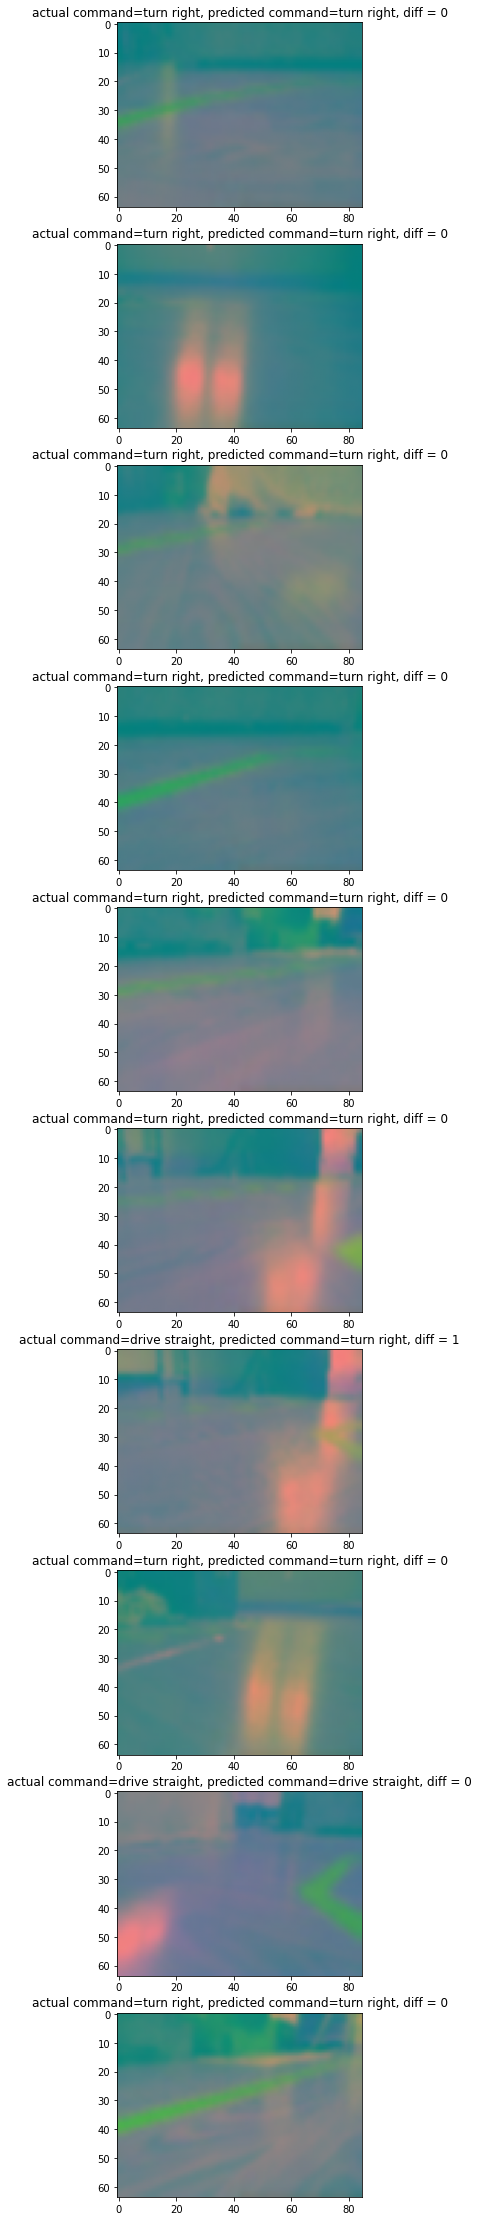

In [75]:
n_tests = 100
x_test, y_test = next(image_data_generator(x_valid, y_valid, 100, False))

y_pred = predict_and_summarize(x_test, y_test)

n_tests_show = 10
fix, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
  axes[i].imshow(x_test[i])
  axes[i].set_title(f"actual command={command_list[y_test[i]]}, predicted command={command_list[y_pred[i]]}, diff = {int(y_pred[i])-y_test[i]}")